In [19]:
import torch
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical

In [701]:
means = torch.tensor([[-4, 4], [0,0], [4, 4]]).float()

m = MultivariateNormal(means, torch.stack([torch.eye(2)]*3))

In [702]:
mm = MixtureSameFamily(Categorical(torch.tensor([0.2]*3)), m)

In [703]:
samples = mm.sample(torch.tensor([10000]))

In [704]:
from matplotlib import pyplot as plt

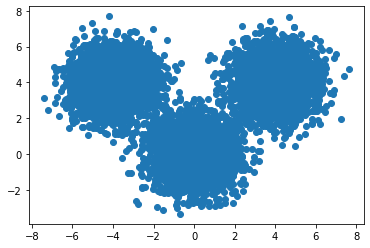

In [705]:
plt.scatter(samples[:, 0], samples[:, 1])

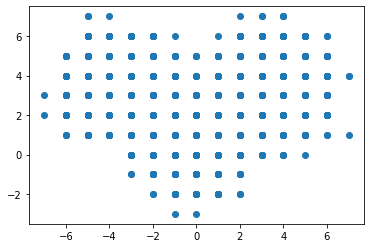

In [706]:
plt.scatter(samples.int()[:, 0], samples.int()[:, 1])

(array([[  0.,   0.,   0.,   0.,   8.,  27.,  35.,  25.,   5.,   0.],
        [  0.,   0.,   0.,   1.,  30., 223., 427., 289.,  64.,   4.],
        [  0.,   0.,   3.,   8.,  59., 366., 715., 471., 111.,   7.],
        [  4.,  33.,  93., 102.,  63.,  73., 186., 123.,  27.,   2.],
        [ 21., 176., 558., 572., 197.,  32.,   6.,   6.,   1.,   0.],
        [ 19., 156., 452., 485., 185.,  23.,  11.,  11.,   1.,   0.],
        [  2.,  20.,  67.,  59.,  45., 128., 219., 146.,  40.,   2.],
        [  0.,   0.,   1.,   7.,  59., 382., 778., 540., 118.,  12.],
        [  0.,   0.,   0.,   2.,  22., 175., 334., 221.,  67.,   6.],
        [  0.,   0.,   0.,   0.,   3.,   8.,  20.,  16.,   5.,   0.]]),
 array([-7.39759731, -5.89550152, -4.39340572, -2.89130993, -1.38921413,
         0.11288166,  1.61497746,  3.11707325,  4.61916904,  6.12126484,
         7.62336063]),
 array([-3.35042906, -2.24606261, -1.14169617, -0.03732972,  1.06703672,
         2.17140317,  3.27576962,  4.38013606,  5.484502

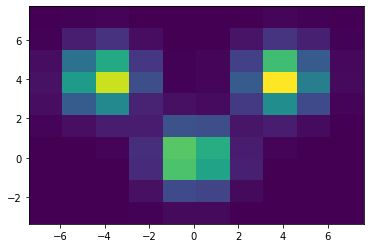

In [707]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())

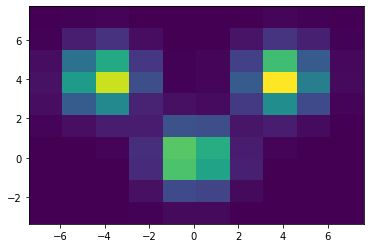

In [708]:
img, x_grid, y_grid, _ = plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())

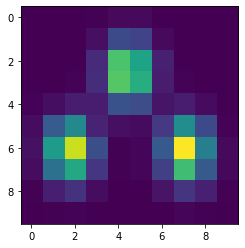

In [709]:
plt.imshow(img.transpose())

To implement the EM algorithm, we need the truncated normal distribution:

- Implementation of truncated multivariate distribution in R: tmvtnorm package
- This could be useful: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html


In [710]:
import rpy2
import numpy as np
from rpy2.robjects import numpy2ri
numpy2ri.activate()

In [711]:
from rpy2.robjects.packages import importr

In [712]:
import rpy2.robjects as robjects

In [713]:
tmv = importr("tmvtnorm")

In [714]:
strr = robjects.r('dim')

In [715]:
np2vec = robjects.r('as.vector')

In [716]:
xxx=robjects.r('list(a=5,b=matrix(c(7,8,27,99), nrow=1))')

In [717]:
xxx[0]

array([5.])

In [718]:
xxx[1]

array([[ 7.,  8., 27., 99.]])

In [719]:
np2vec

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7efee6a83d40> [RTYPES.CLOSXP]
R classes: ('function',)

In [720]:
np2vec(means[0].numpy().astype(np.float64)

SyntaxError: unexpected EOF while parsing (2403992266.py, line 1)

In [721]:
x = robjects.r.rnorm(100)

In [722]:
x.r_repr

AttributeError: 'numpy.ndarray' object has no attribute 'r_repr'

In [723]:
mtmvnorm = robjects.r('function(m, l) tmvtnorm::mtmvnorm(as.vector(m), lower=as.vector(l), doComputeVariance=FALSE)$tmean')

In [724]:
mtmvnorm(means[0].numpy(), l=np.array([0.,0.]))

array([0.22560714, 4.00013383])

In [725]:
from importlib import reload
import trunc_mvnorm
reload(trunc_mvnorm)

<module 'trunc_mvnorm' from '/home/derek/meta_repo/bliss/case_studies/galaxy_identifiability/trunc_mvnorm.py'>

In [726]:
tm = trunc_mvnorm.TruncMVNorm()

In [727]:
tm.mtmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

(array([[ 0.21683078,  0.73954571],
        [-0.73954571, -0.21683078]]),
 array([[[ 3.82902873e-02, -2.21707097e-11],
         [-2.21707097e-11,  4.92777938e-02]],
 
        [[ 4.92777938e-02,  8.27427016e-12],
         [ 8.27427016e-12,  3.82902873e-02]]]))

In [728]:
tm.pmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

array([[4.13720077e-08],
       [4.13720077e-08]])

In [729]:
x_grid

array([-7.39759731, -5.89550152, -4.39340572, -2.89130993, -1.38921413,
        0.11288166,  1.61497746,  3.11707325,  4.61916904,  6.12126484,
        7.62336063])

In [730]:
y_grid

array([-3.35042906, -2.24606261, -1.14169617, -0.03732972,  1.06703672,
        2.17140317,  3.27576962,  4.38013606,  5.48450251,  6.58886895,
        7.6932354 ])

In [731]:
from einops import rearrange, repeat, reduce

In [732]:
x_limits = repeat(np.stack([x_grid[:-1], x_grid[1:]], axis=1), "x p -> x 10 p")

In [733]:
y_limits = repeat(np.stack([y_grid[:-1], y_grid[1:]], axis=1), "y p -> 10 y p")

In [734]:
x_limits.shape

(10, 10, 2)

In [735]:
y_limits.shape

(10, 10, 2)

In [736]:
limits = np.concatenate([x_limits, y_limits], axis=2)

In [737]:
limits.shape

(10, 10, 4)

In [738]:
limits[0,0]

array([-7.39759731, -5.89550152, -3.35042906, -2.24606261])

In [739]:
limits_long = rearrange(limits, "X Y L -> (X Y) L")

In [740]:
res = tm.mtmvnorm(means[0].numpy(), None, limits_long[:, [0,2]], limits_long[:, [1,3]])
res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)

In [741]:
res_mean.shape

(10, 10, 2)

In [742]:
limits[-1, -1]

array([6.12126484, 7.62336063, 6.58886895, 7.6932354 ])

In [743]:
res_mean[-1, -1]

array([6.21822556, 6.58886895])

In [744]:
res_var[-1, -1]

array([[9.23220109e-03, 2.94246776e+01],
       [2.94246776e+01, 1.00000000e+00]])

In [745]:
## Basic EM algorithm
from sklearn.cluster import KMeans

samples_pixel = samples.int() + 0.5
km = KMeans(n_clusters=3)
km.fit(samples_pixel)
km.cluster_centers_

array([[ 4.025383  ,  4.01096425],
       [-3.00837648,  3.9980201 ],
       [ 0.4890791 ,  0.53040142]])

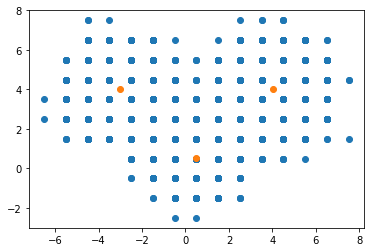

In [746]:
plt.scatter(samples_pixel[:, 0], samples_pixel[:, 1])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])

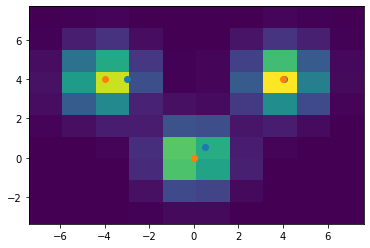

In [747]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [748]:
from tqdm import tqdm

In [749]:
def basic_em(grid, limits, mu_start, pi_start, n_iter):
    grid_long = rearrange(grid, "X Y -> (X Y)")
    limits_long = rearrange(limits, "X Y L -> (X Y) L")
    limits_lower_long = limits_long[:, [0,2]]
    limits_upper_long = limits_long[:, [1,3]]
    mu = np.copy(mu_start)
    pi = np.copy(pi_start)
    for _ in tqdm(range(n_iter)):
        ## E-step
        ## Calculate log-probability of each cluster
        probs_list = []
        for j in range(mu.shape[0]):
            ## Get expectation in each pixel
            #res = tm.mtmvnorm(mus[j], None, limits_long[:, [0,2]], limits_long[:, [1,3]])
            #res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
            #res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)
            ## Calculate the log-probability
            probs_j = tm.pmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            probs_list.append(probs_j)
        probs_long = np.stack(probs_list)
        #return(probs_long)
        #print(probs_long)
        probs = rearrange(probs_long, "K (X Y) 1 -> K X Y", X=10, Y=10)
        ## Multiply by the prior
        probs = rearrange(pi, "K -> K 1 1") * probs

        ## M-step
        prob_global = reduce((probs * grid), "K X Y -> K", "sum")
        pi = prob_global / prob_global.sum()
        
        for j in range(mu.shape[0]):
            probs_j = probs[j]
            #print(probs_j.shape)
            W = rearrange(probs_j * grid, "X Y -> X Y 1")
            
            res = tm.mtmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
            #return res[0]
            mu[j] = reduce(W * res_mean, "X Y A -> A", "sum")
            mu[j] = mu[j] / (W).sum()
            print(mu[j])
    return mu, pi
            
        
            
            

In [750]:
output = basic_em(img, limits, km.cluster_centers_, np.ones(3)/3, 100)

  0%|                                                          | 0/100 [00:00<?, ?it/s]

[4.00378765 4.00093554]
[-3.42159104  3.97855108]


  1%|▌                                                 | 1/100 [00:02<03:19,  2.02s/it]

[0.2943079 0.3136951]
[3.99245821 3.99528875]
[-3.64923944  3.96976709]


  2%|█                                                 | 2/100 [00:02<02:11,  1.34s/it]

[0.16688221 0.1867828 ]
[3.9865199  3.99210975]
[-3.77490317  3.96541132]


  3%|█▌                                                | 3/100 [00:03<01:46,  1.10s/it]

[0.08499018 0.11372761]
[3.98340819 3.990321  ]
[-3.84526416  3.96318585]


  4%|██                                                | 4/100 [00:04<01:34,  1.02it/s]

[0.03292535 0.07197048]
[3.98177759 3.98931521]
[-3.88508809  3.96203746]


  5%|██▌                                               | 5/100 [00:05<01:27,  1.09it/s]

[6.33274025e-05 4.81828772e-02]
[3.98092295 3.98875009]
[-3.90778031  3.96144362]


  6%|███                                               | 6/100 [00:06<01:30,  1.04it/s]

[-0.02057782  0.03465405]
[3.9804749  3.98843279]
[-3.92076218  3.96113714]


  7%|███▌                                              | 7/100 [00:07<01:25,  1.09it/s]

[-0.03350139  0.02696512]
[3.98023992 3.98825477]
[-3.9282061  3.9609797]


  8%|████                                              | 8/100 [00:07<01:21,  1.13it/s]

[-0.04157601  0.0225958 ]
[3.98011665 3.98815495]
[-3.93248023  3.9608994 ]


  9%|████▌                                             | 9/100 [00:08<01:17,  1.17it/s]

[-0.04661407  0.02011231]
[3.98005195 3.98809901]
[-3.93493623  3.96085882]


 10%|████▉                                            | 10/100 [00:09<01:15,  1.20it/s]

[-0.04975464  0.01870002]
[3.98001797 3.98806769]
[-3.93634813  3.96083856]


 11%|█████▍                                           | 11/100 [00:10<01:13,  1.22it/s]

[-0.05171116  0.01789634]
[3.98000013 3.98805015]
[-3.93716001  3.96082861]


 12%|█████▉                                           | 12/100 [00:11<01:11,  1.24it/s]

[-0.0529295   0.01743863]
[3.97999075 3.98804034]
[-3.93762693  3.96082383]


 13%|██████▎                                          | 13/100 [00:11<01:09,  1.25it/s]

[-0.05368794  0.0171777 ]
[3.97998582 3.98803486]
[-3.93789548  3.9608216 ]


 14%|██████▊                                          | 14/100 [00:12<01:08,  1.25it/s]

[-0.05415996  0.01702879]
[3.97998323 3.98803179]
[-3.93804995  3.9608206 ]


 15%|███████▎                                         | 15/100 [00:13<01:07,  1.26it/s]

[-0.05445368  0.01694371]
[3.97998186 3.98803008]
[-3.93813881  3.96082018]


 16%|███████▊                                         | 16/100 [00:14<01:10,  1.19it/s]

[-0.05463643  0.01689504]
[3.97998114 3.98802912]
[-3.93818992  3.96082003]


 17%|████████▎                                        | 17/100 [00:15<01:08,  1.21it/s]

[-0.05475011  0.01686716]
[3.97998076 3.98802858]
[-3.93821932  3.96081999]


 18%|████████▊                                        | 18/100 [00:16<01:07,  1.22it/s]

[-0.05482082  0.01685117]
[3.97998056 3.98802829]
[-3.93823623  3.96082   ]


 19%|█████████▎                                       | 19/100 [00:17<01:09,  1.16it/s]

[-0.0548648   0.01684197]
[3.97998046 3.98802812]
[-3.93824596  3.96082002]


 20%|█████████▊                                       | 20/100 [00:18<01:13,  1.09it/s]

[-0.05489215  0.01683668]
[3.9799804  3.98802803]
[-3.93825155  3.96082004]


 21%|██████████▎                                      | 21/100 [00:18<01:10,  1.11it/s]

[-0.05490916  0.01683363]
[3.97998037 3.98802798]
[-3.93825477  3.96082005]


 22%|██████████▊                                      | 22/100 [00:19<01:08,  1.13it/s]

[-0.05491974  0.01683187]
[3.97998036 3.98802795]
[-3.93825662  3.96082006]


 23%|███████████▎                                     | 23/100 [00:20<01:08,  1.12it/s]

[-0.05492631  0.01683085]
[3.97998035 3.98802793]
[-3.93825769  3.96082007]


 24%|███████████▊                                     | 24/100 [00:21<01:05,  1.15it/s]

[-0.0549304   0.01683026]
[3.97998034 3.98802792]
[-3.9382583   3.96082008]


 25%|████████████▎                                    | 25/100 [00:22<01:05,  1.15it/s]

[-0.05493295  0.01682992]
[3.97998034 3.98802792]
[-3.93825865  3.96082008]


 26%|████████████▋                                    | 26/100 [00:23<01:05,  1.13it/s]

[-0.05493453  0.01682972]
[3.97998034 3.98802791]
[-3.93825886  3.96082008]


 27%|█████████████▏                                   | 27/100 [00:24<01:03,  1.14it/s]

[-0.05493551  0.0168296 ]
[3.97998034 3.98802791]
[-3.93825897  3.96082008]


 28%|█████████████▋                                   | 28/100 [00:25<01:06,  1.08it/s]

[-0.05493612  0.01682953]
[3.97998034 3.98802791]
[-3.93825904  3.96082008]


 29%|██████████████▏                                  | 29/100 [00:26<01:06,  1.07it/s]

[-0.0549365   0.01682949]
[3.97998034 3.98802791]
[-3.93825908  3.96082008]


 30%|██████████████▋                                  | 30/100 [00:27<01:06,  1.06it/s]

[-0.05493674  0.01682947]
[3.97998034 3.98802791]
[-3.9382591   3.96082008]


 31%|███████████████▏                                 | 31/100 [00:27<01:03,  1.09it/s]

[-0.05493688  0.01682946]
[3.97998034 3.98802791]
[-3.93825911  3.96082008]


 32%|███████████████▋                                 | 32/100 [00:28<01:01,  1.11it/s]

[-0.05493697  0.01682945]
[3.97998034 3.98802791]
[-3.93825912  3.96082008]


 33%|████████████████▏                                | 33/100 [00:29<00:59,  1.13it/s]

[-0.05493703  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 34%|████████████████▋                                | 34/100 [00:30<00:57,  1.15it/s]

[-0.05493707  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 35%|█████████████████▏                               | 35/100 [00:31<00:56,  1.16it/s]

[-0.05493709  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 36%|█████████████████▋                               | 36/100 [00:32<00:54,  1.17it/s]

[-0.0549371   0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 37%|██████████████████▏                              | 37/100 [00:33<00:53,  1.17it/s]

[-0.05493711  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 38%|██████████████████▌                              | 38/100 [00:33<00:53,  1.16it/s]

[-0.05493711  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 39%|███████████████████                              | 39/100 [00:34<00:56,  1.08it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 40%|███████████████████▌                             | 40/100 [00:35<00:57,  1.05it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 41%|████████████████████                             | 41/100 [00:36<00:56,  1.05it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 42%|████████████████████▌                            | 42/100 [00:37<00:55,  1.05it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 43%|█████████████████████                            | 43/100 [00:38<00:53,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 44%|█████████████████████▌                           | 44/100 [00:39<00:50,  1.10it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 45%|██████████████████████                           | 45/100 [00:40<00:48,  1.13it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 46%|██████████████████████▌                          | 46/100 [00:41<00:47,  1.14it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 47%|███████████████████████                          | 47/100 [00:42<00:46,  1.15it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 48%|███████████████████████▌                         | 48/100 [00:43<00:46,  1.12it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 49%|████████████████████████                         | 49/100 [00:44<00:47,  1.08it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 50%|████████████████████████▌                        | 50/100 [00:45<00:46,  1.08it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 51%|████████████████████████▉                        | 51/100 [00:46<00:46,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 52%|█████████████████████████▍                       | 52/100 [00:46<00:45,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 53%|█████████████████████████▉                       | 53/100 [00:47<00:44,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 54%|██████████████████████████▍                      | 54/100 [00:48<00:43,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 55%|██████████████████████████▉                      | 55/100 [00:49<00:43,  1.03it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 56%|███████████████████████████▍                     | 56/100 [00:50<00:42,  1.04it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 57%|███████████████████████████▉                     | 57/100 [00:51<00:40,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 58%|████████████████████████████▍                    | 58/100 [00:52<00:39,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 59%|████████████████████████████▉                    | 59/100 [00:53<00:38,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 60%|█████████████████████████████▍                   | 60/100 [00:54<00:36,  1.11it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 61%|█████████████████████████████▉                   | 61/100 [00:55<00:34,  1.13it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 62%|██████████████████████████████▍                  | 62/100 [00:56<00:32,  1.15it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 63%|██████████████████████████████▊                  | 63/100 [00:56<00:32,  1.15it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 64%|███████████████████████████████▎                 | 64/100 [00:57<00:31,  1.13it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 65%|███████████████████████████████▊                 | 65/100 [00:58<00:31,  1.12it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 66%|████████████████████████████████▎                | 66/100 [00:59<00:31,  1.09it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 67%|████████████████████████████████▊                | 67/100 [01:00<00:30,  1.09it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 68%|█████████████████████████████████▎               | 68/100 [01:01<00:30,  1.05it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 69%|█████████████████████████████████▊               | 69/100 [01:02<00:29,  1.05it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 70%|██████████████████████████████████▎              | 70/100 [01:03<00:28,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 71%|██████████████████████████████████▊              | 71/100 [01:04<00:27,  1.04it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 72%|███████████████████████████████████▎             | 72/100 [01:05<00:27,  1.01it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 73%|███████████████████████████████████▊             | 73/100 [01:06<00:26,  1.03it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 74%|████████████████████████████████████▎            | 74/100 [01:07<00:24,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 75%|████████████████████████████████████▊            | 75/100 [01:08<00:23,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 76%|█████████████████████████████████████▏           | 76/100 [01:09<00:23,  1.04it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 77%|█████████████████████████████████████▋           | 77/100 [01:10<00:22,  1.03it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 78%|██████████████████████████████████████▏          | 78/100 [01:11<00:20,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 79%|██████████████████████████████████████▋          | 79/100 [01:12<00:19,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 80%|███████████████████████████████████████▏         | 80/100 [01:13<00:18,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 81%|███████████████████████████████████████▋         | 81/100 [01:14<00:17,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 82%|████████████████████████████████████████▏        | 82/100 [01:14<00:16,  1.09it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 83%|████████████████████████████████████████▋        | 83/100 [01:15<00:15,  1.13it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 84%|█████████████████████████████████████████▏       | 84/100 [01:16<00:14,  1.13it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 85%|█████████████████████████████████████████▋       | 85/100 [01:17<00:12,  1.16it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 86%|██████████████████████████████████████████▏      | 86/100 [01:18<00:11,  1.17it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 87%|██████████████████████████████████████████▋      | 87/100 [01:19<00:10,  1.20it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 88%|███████████████████████████████████████████      | 88/100 [01:19<00:10,  1.16it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 89%|███████████████████████████████████████████▌     | 89/100 [01:20<00:09,  1.15it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 90%|████████████████████████████████████████████     | 90/100 [01:21<00:08,  1.15it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 91%|████████████████████████████████████████████▌    | 91/100 [01:22<00:07,  1.14it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 92%|█████████████████████████████████████████████    | 92/100 [01:23<00:07,  1.12it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 93%|█████████████████████████████████████████████▌   | 93/100 [01:24<00:06,  1.07it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 94%|██████████████████████████████████████████████   | 94/100 [01:25<00:05,  1.06it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 95%|██████████████████████████████████████████████▌  | 95/100 [01:26<00:04,  1.02it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 96%|███████████████████████████████████████████████  | 96/100 [01:27<00:03,  1.00it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 97%|███████████████████████████████████████████████▌ | 97/100 [01:28<00:03,  1.02s/it]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 98%|████████████████████████████████████████████████ | 98/100 [01:29<00:02,  1.01s/it]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


 99%|████████████████████████████████████████████████▌| 99/100 [01:30<00:00,  1.05it/s]

[-0.05493712  0.01682944]
[3.97998034 3.98802791]
[-3.93825913  3.96082008]


100%|████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]

[-0.05493712  0.01682944]


In [696]:
output

(array([[-0.015049  ,  0.81271935],
        [-0.01498607,  0.81271529],
        [-0.01501937,  0.81271744]]),
 array([0.23442365, 0.12172912, 0.64384722]))

In [697]:
np.ones(3)/3

array([0.33333333, 0.33333333, 0.33333333])

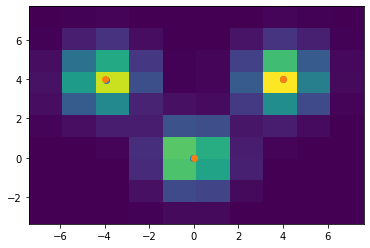

In [751]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())
plt.scatter(output[0][:, 0], output[0][:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [576]:
km.cluster_centers_

array([[0.17076923, 1.86      ],
       [1.84328358, 0.82835821],
       [0.14345992, 0.35021097]])

- Almost spot on when "galaxies" are clearly separated (4, -4), (0,0), (4, 4)
- EM converges to center when closer together